In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

spark = SparkSession.builder \
    .appName('DataFrame') \
    .master('local[*]') \
    .getOrCreate()

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import DataFrame, SQLContext

In [3]:
from os import listdir
from os.path import isfile

In [9]:
input_path = '/home/jovyan/work/data/'

In [79]:
datasets = [directory for directory in listdir(input_path) if not isfile(input_path + directory)]
datasets.remove('.ipynb_checkpoints')

In [194]:
users_schema = StructType([
    StructField("_AboutMe", StringType()),
    StructField("_AccountId", IntegerType()),
    StructField("_CreationDate", DateType()),
    StructField("_DisplayName", StringType()),
    StructField("_Id", IntegerType()),
    StructField("_LastAccessDate", DateType()),
    StructField("_Location", StringType()),
    StructField("forum", StringType())
])

comments_schema = StructType([
    StructField("_CreationDate", DateType()),
    StructField("_Id", IntegerType()),
    StructField("_PostId", IntegerType()),
    StructField("_Text", StringType()),
    StructField("_UserDisplayName", StringType()),
    StructField("_UserId", IntegerType()),
    StructField("_AccountId", IntegerType()),
    StructField("UserId", IntegerType()),
    StructField("forum", StringType())
])

posts_schema = StructType([
    StructField("_AnswerCount", IntegerType()),
    StructField("_Body", StringType()),
    StructField("_ClosedDate", DateType()),
    StructField("_CommentCount", IntegerType()),
    StructField("_CreationDate", DateType()),
    StructField("_Id", IntegerType()),
    StructField("_LastActivityDate", DateType()),
    StructField("_LastEditDate", DateType()),
    StructField("_LastEditorUserId", IntegerType()),
    StructField("_OwnerUserId", IntegerType()),
    StructField("_ParentId", IntegerType()),
    StructField("_PostTypeId", IntegerType()),
    StructField("_Tags", StringType()),
    StructField("_Title", StringType()),
    StructField("_ViewCount", IntegerType()),
    StructField("forum", StringType()),    
    StructField("UserId2", IntegerType()),
    StructField("LastEditorAccountId", IntegerType()),
    StructField("UserId", IntegerType()),
    StructField("OwnerAccountId", IntegerType())
])

In [195]:
comments_cols = comments_schema.fieldNames()
posts_cols = posts_schema.fieldNames()
users_cols = users_schema.fieldNames()

In [17]:
def read_xml(path, file_name, columns):
    full_path = f'{path}/{file_name}.xml'
    
    ddf = spark.read \
            .format('com.databricks.spark.xml') \
            .options(rootTag=file_name, rowTag='row') \
            .load(full_path)
    
    ddf = ddf.select([c for c in ddf.columns if c in columns])
    
    return ddf

In [18]:
def add_column(ddf, forum_name):
    return ddf.withColumn('forum', lit(forum_name))

In [196]:
all_users = spark.createDataFrame([], users_schema)
all_comments = spark.createDataFrame([], comments_schema)
all_posts = spark.createDataFrame([], posts_schema)

for data in datasets:
    users = read_xml(path=input_path+data, file_name='Users', columns=users_cols)
    users = add_column(ddf=users, forum_name=data)
    users = users.withColumnRenamed('_Id', 'UserId')

    comments = read_xml(path=input_path+data, file_name='Comments', columns=comments_cols)
    comments = add_column(ddf=comments, forum_name=data)
    
    posts = read_xml(path=input_path+data, file_name='Posts', columns=posts_cols)
    posts = add_column(ddf=posts, forum_name=data)
    
    comments = comments.join(users['UserId', '_AccountId'], users['UserId'] == comments['_UserId'], how='inner')   
    all_comments = all_comments.union(comments)
    
    posts = posts.join(users['UserId', '_AccountId'], users['UserId'] == posts['_LastEditorUserId'], how='inner')
    posts = posts.withColumnRenamed('_AccountId', 'LastEditorAccountId')
    posts = posts.drop('UserId')
    posts = posts.join(users['UserId', '_AccountId'], users['UserId'] == posts['_OwnerUserId'], how='inner')
    posts = posts.withColumnRenamed('_AccountId', 'OwnerAccountId')
    posts = posts.drop('UserId')
    all_posts = all_posts.union(posts)
    
    all_users = all_users.union(users)

root
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable = true)
 |-- _LastEditDate: string (nullable = true)
 |-- _LastEditorUserId: long (nullable = true)
 |-- _OwnerUserId: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _ViewCount: long (nullable = true)
 |-- forum: string (nullable = false)
 |-- UserId2: long (nullable = true)
 |-- LastEditorAccountId: long (nullable = true)
 |-- UserId: long (nullable = true)
 |-- OwnerAccountId: long (nullable = true)

root
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)

In [197]:
print('users')
all_users.printSchema()
print('comments')
all_comments.printSchema()
print('posts')
posts.printSchema()

users
root
 |-- _AboutMe: string (nullable = true)
 |-- _AccountId: long (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _DisplayName: string (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastAccessDate: string (nullable = true)
 |-- _Location: string (nullable = true)
 |-- forum: string (nullable = true)

comments
root
 |-- _CreationDate: string (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _PostId: long (nullable = true)
 |-- _Text: string (nullable = true)
 |-- _UserDisplayName: string (nullable = true)
 |-- _UserId: long (nullable = true)
 |-- _AccountId: string (nullable = true)
 |-- UserId: long (nullable = true)
 |-- forum: string (nullable = true)

posts
root
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable

In [83]:
users_counts = all_users.groupBy('_AccountId').count() #.orderBy('count', ascending=0) #.show()

# the number of individual, paired, triple and 4th accounts
users_counts.groupby('count').count().orderBy('count').show()

+-----+------+
|count| count|
+-----+------+
|    7|    86|
|    6|    73|
|    5|   170|
|    1|128744|
|    3|  1023|
|    8|   228|
|    2|  5173|
|    4|   428|
+-----+------+



In [127]:
users_by_forum = all_users.groupBy('forum').count().orderBy('count', ascending=0)
users_by_forum.show()

+-------------+-----+
|        forum|count|
+-------------+-----+
|    chemistry|73116|
|       french|20358|
|      spanish|17514|
| windowsphone|16468|
|    mythology| 6077|
|      italian| 6032|
|   portuguese| 5140|
|vegetarianism| 2880|
+-------------+-----+



In [111]:
all_users.count()

147585

In [85]:
forum_list = all_users.groupBy('_AccountId').agg(collect_set('forum').alias('joined_forums'))

In [86]:
forum_list.printSchema()

root
 |-- _AccountId: long (nullable = true)
 |-- joined_forums: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [106]:
x=forum_list.groupBy(['joined_forums']).agg(count('_AccountId').alias('users'))

In [107]:
x=x.withColumn('array size', size(x['joined_forums']))

In [110]:
x.orderBy('users', ascending=0).show(100, truncate=False)

+-----------------------------------------------------------------------------------------+-----+----------+
|joined_forums                                                                            |users|array size|
+-----------------------------------------------------------------------------------------+-----+----------+
|[chemistry]                                                                              |68881|1         |
|[french]                                                                                 |16533|1         |
|[windowsphone]                                                                           |14919|1         |
|[spanish]                                                                                |14257|1         |
|[italian]                                                                                |4433 |1         |
|[mythology]                                                                              |4046 |1         |
|[portuguese]      

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [128]:
users_by_forum = users_by_forum.toPandas()

In [156]:
sns.set(rc={'figure.figsize':(12, 9)})

[Text(0.5, 1.0, 'Top 10 the most popular forums'),
 Text(0, 0.5, 'Number of users')]

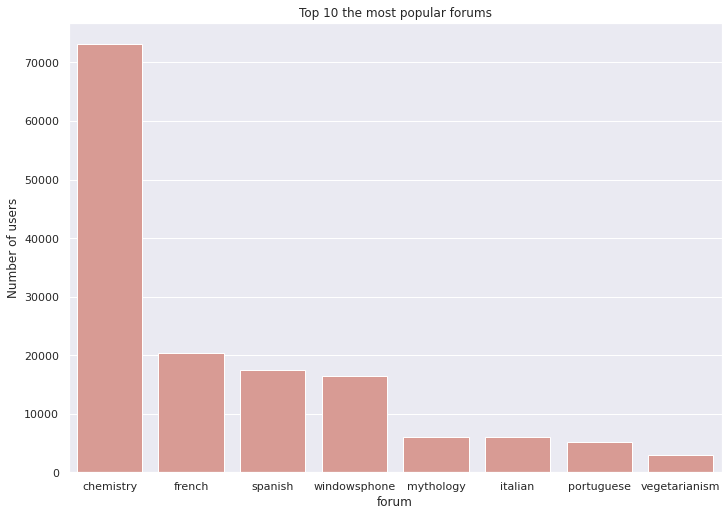

In [161]:
ax = sns.barplot(x=users_by_forum['forum'], y=users_by_forum['count'], data=users_by_forum, color='salmon',
                saturation=.5)
ax.set(title='Top 10 the most popular forums', ylabel='Number of users', xlabel='Forum')

In [162]:
# add heatmap

In [198]:
all_comments.count()

280498

In [213]:
all_users.coalesce(1).rdd.getNumPartitions()

12

Write Data to csv files

In [216]:
all_users.coalesce(1).write.csv(path=input_path+'all_users_v1', mode='overwrite', header=True)
all_comments.coalesce(10).write.csv(path=input_path+'all_comments_v1', mode='overwrite', header=True)
all_posts.coalesce(10).write.csv(path=input_path+'all_posts_v1', mode='overwrite', header=True)